In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.animation import PillowWriter 
import seaborn as sns

from animation import run_animation
from helper_functions import *
from plots import *

In [2]:
class BacteriaInfection():
    """This represents the bacteria infection """
    def __init__(self, init_state, m, n, bacterium_factor, TIMER_ADAPATIVE_SYSTEM):
        self.init_state = init_state.copy()
        self.TIMER_ADAPATIVE_SYSTEM = TIMER_ADAPATIVE_SYSTEM
        self.bacterium_factor = bacterium_factor
        self.state = init_state.copy()
        self.flag_call_ais = False # flag for the adaptive inmmune system
        self.turns = 0 
        self.m = m # m t-cell will be realeased once adaptive system is activated
        self.n = n # kill n bacteria / add n macrophage cells when t-cell is called
        self.AIS_ts = [] # time at which adaptive ims was called
        self.n_macrophage = n # number of bacteria to kill
        self.bacteria_killed_by_macrophage = 0
        self.bacteria_killed_by_dendritic = 0
        
    def bacteria(self, t):
        """ Evil cells that drains the body’s resources and after some 
        (random) time divide into multiple copies of itself."""
        self.state.extend(['bacteria']*self.bacterium_factor)

    def macrophage(self, t):
        """Innate immune cells that try to eat bacteria when it encounters 
        them, and start asking for reinforcements if there are many bacteria."""
        
        # (Phagocytosis))remove n bacteria. This is updated when macrophage encourgament
        for i in range(self.n_macrophage):
            self.remove_bacteria()
            self.bacteria_killed_by_macrophage+=1
        
        # (Cytokine release): Add m macrophages to the box
        self.state.extend(['macrophage']*self.m)
        
    def dendritic(self, t):
        """Innate immune cells that pick up pieces of (dead) bacteria and use these to activate the adaptive immune system."""
        
        # remove n bacteria
        for i in range(self.n):
            self.remove_bacteria()
            self.bacteria_killed_by_dendritic +=1
            
        # Start a timer of t turns. If this timer off, add m helper T-cells to the box.
        self.flag_call_ais = True 
        
        # only save if there is bacteria to kill
        if "bacteria" in self.state:
            self.AIS_ts.append(t)
 
    def t_cell(self,t):
        """Adaptive immune cells that can activate specific weapons against a species of bacteria.
        After activation by a dendritic cell they rapidly multiply and start activating B-cells."""
        # encourage the macrophage to eat more bacteria
        self.macrophage_encouragement()
        # b-cell activation 
        self.state.append("b_cell")
        # Add n macrophages to the box
        self.state.extend(['macrophage']*self.n)
        
    def b_cell(self, t):
        """Adaptive immune cells that produce antibodies. These antibodies cover bacteria, 
        making it harder for them to multiply, and easier for macrophages to eat them. B-cells
        need to be activated by helper T-cells and can also multiply rapidly after activation."""
        # half the multiplicative factor of bacteria if larger than 1
        self.bacterium_factor = [self.bacterium_factor//2 if self.bacterium_factor>1 else 1][0]
        self.macrophage_encouragement()
        
    def macrophage_encouragement(self):
        # increment the number of bacteria to be eaten at by macrophage cells
        self.n_macrophage += 1
        
    def action(self, cell_type, t):
        # bacteria behavior
        actions = {
                    "bacteria": self.bacteria,
                    "macrophage": self.macrophage,
                    "dendritic": self.dendritic,
                    "t_cell" : self.t_cell,
                    "b_cell" : self.b_cell
                   }
        # Get the function from actions dictionary
        func = actions.get(cell_type, "nothing")
        # Execute the function
        func(t)
  
    def antigen_presentation(self):
        # number of turns after ais has been called
        self.turns += 1  
        
        # activate adaptive system
        if (self.turns % self.TIMER_ADAPATIVE_SYSTEM) == 0 :
            self.state.extend(['t_cell']*self.m)
            # print('Adaptive inmmune system has been activated. {} helper t-cell were realeased!'.format(self.m))
            self.flag_call_ais=False
            self.turns = 0
                
    def remove_bacteria(self):
        if "bacteria" in self.state:
            self.state.remove("bacteria")
        else: 
            #print("There is no more bacteria to eat!")
            pass

    def mutate(self, t): 
        """ The infection start spreading 
            generates a new cell and each cell produce an effect in the body """
        # draw a cell uniformly at random (with replacement)
        cell = np.random.choice(self.state, replace=True)
        
        # performa action 
        self.action(cell, t)
        
        # check when to activate adaptive inmmune system
        if self.flag_call_ais == True:             
            self.antigen_presentation() 
    
        return cell 
    
    def simulation(self):
        """ Run the simulation """
        pass

# 1. Understanding the soldiers of your body

In [3]:
# general settings 
fig_dir = './images/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

## 1.1 Simple example
This is a simple implementation considering that the delay time between the called from the innate system and the adaptive system is inmediate (t=1). This will help us to understand the functions of each cell. 

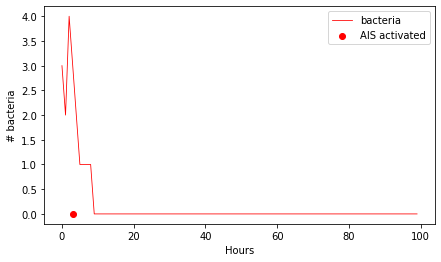

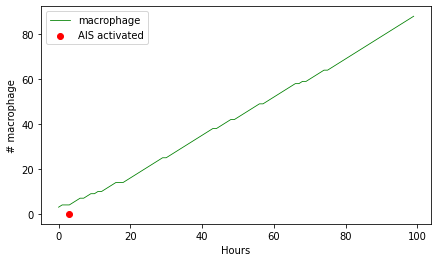

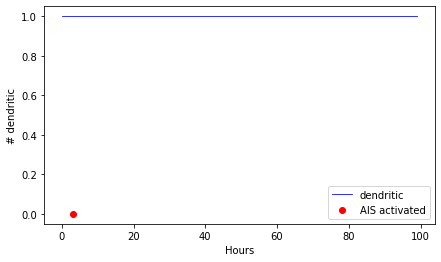

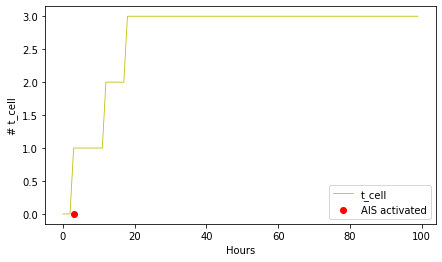

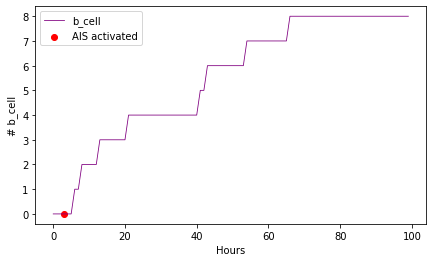

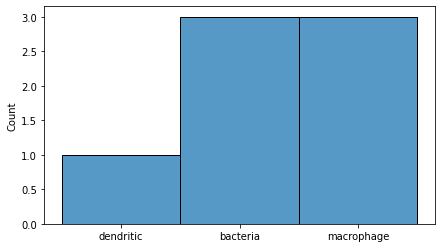

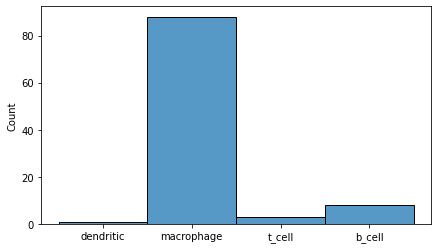

Case: Bacteria was killed
Max number of bacteria at some point : 4.0
Max number of macrophage at some point : 88.0
Max number of dendritic at some point : 1.0
Max number of t_cell at some point : 3.0
Max number of b_cell at some point : 8.0
Max ratio bacteria/macrophage 1.0 at t=-1 no. bacteria 3.0 no. macrophage 3.0
Bacteria killed by macrophage:  1019
Bacteria killed by dendritic:  3
Number ot times AIS was called:  1


In [26]:
get_ipython().magic('matplotlib inline')

# parameters
delay_ads = 1  # set the number of turns that takes to bring the adaptive inmmune system
m = 1  # m t-cell will be realeased once adaptive system is activated
n_ = 1 # kill n bacteria / add n macrophage cells wehn t-cell is called
bf = 2 # bacterium factor: number of bacteria multiplicity

# create an instance of the initial state of the system
init_state_bacteria = init_state(lambda_ = 3)

# simulate the process
Ts, states, infection = simulate(init_state_bacteria, BacteriaInfection, m, n_, bf, delay_ads, T=100)
 
name="exp1"
plot_cell(Ts, states, infection, "bacteria", "red", name, fig_dir)
plot_cell(Ts, states, infection, "macrophage", "green", name, fig_dir)
plot_cell(Ts, states, infection, "dendritic", "blue", name, fig_dir)
plot_cell(Ts, states, infection, "t_cell", "y", name, fig_dir)
plot_cell(Ts, states, infection, "b_cell", "purple", name, fig_dir)
plot_state(infection.init_state, name, "init", fig_dir)
plot_state(infection.state, name, "end", fig_dir)

# getting some statistics
get_statistics(infection, states)

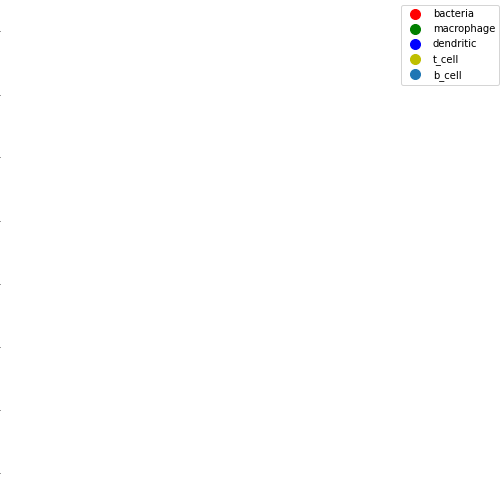

In [27]:
get_ipython().magic('matplotlib widget') 
anim =run_animation(states, infection.AIS_ts, interval=100)  

In [28]:
# save animation
writergif = PillowWriter(fps=100)
anim.save("./animation.gif", dpi=100, writer=writergif)

**What is the stationary distribution for each state**? 

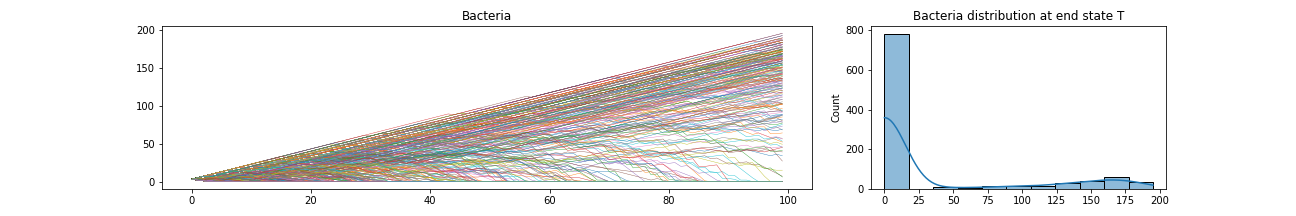

In [29]:
# number of simulations
n=1000
T=100
paths = run_simulations(n, init_state_bacteria, BacteriaInfection, m, n_, bf, delay_ads, T, name, fig_dir)

In [15]:
(len(paths) - np.count_nonzero(paths))/n

0.745

## 1.2 A more realistic approach 

A more realistic approach involves taking into account the time it takes for the adaptive system to response once it has been called by the innate system. 

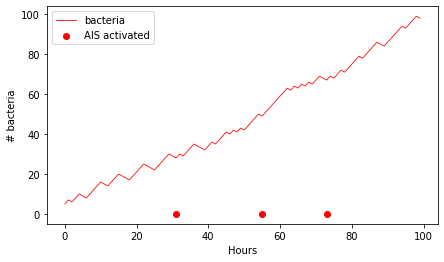

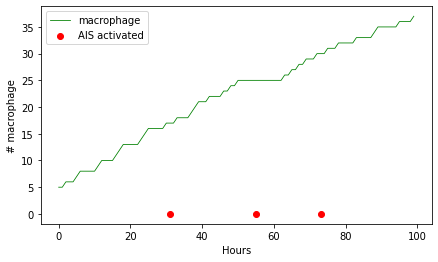

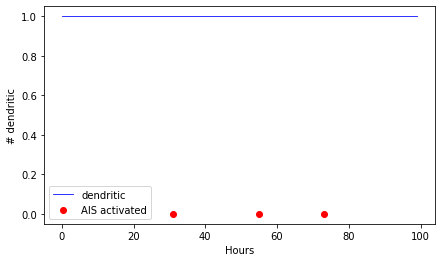

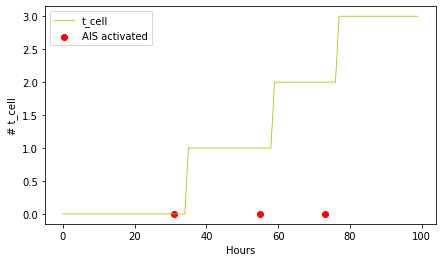

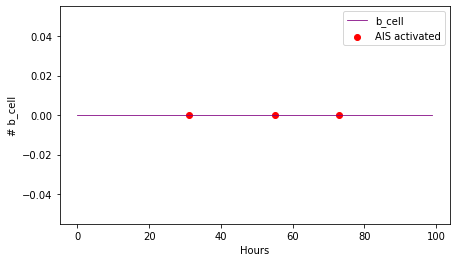

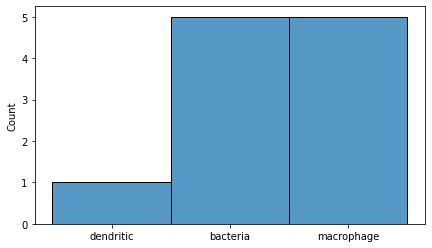

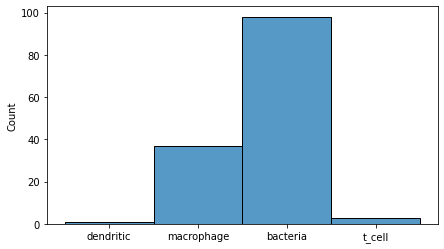

Bacteria was not killed
Number of bacteria 98
Max number of bacteria at some point : 99.0
Max number of macrophage at some point : 37.0
Max number of dendritic at some point : 1.0
Max number of t_cell at some point : 3.0
Max number of b_cell at some point : 0.0
Max ratio bacteria/macrophage 2.75 at t=97 no. bacteria 99.0 no. macrophage 36.0
Bacteria killed by macrophage:  32
Bacteria killed by dendritic:  3
Number ot times AIS was called:  3


In [30]:
get_ipython().magic('matplotlib inline')

# parameters
delay_ads = 5  # set the number of turns that takes to bring the adaptive inmmune system
m = 1  # m t-cell will be realeased once adaptive system is activated
n_ = 1 # add n macrophage cells when t-cell is called
bf = 2 # bacterium factor: number of bacteria multiplicity

# create an instance of the initial state of the system
init_state_bacteria = init_state(lambda_ = 3)

# simulate the process
Ts, states, infection = simulate(init_state_bacteria, BacteriaInfection, m, n_, bf, delay_ads, T=100)
 
name="exp2"
plot_cell(Ts, states, infection, "bacteria", "red", name, fig_dir)
plot_cell(Ts, states, infection, "macrophage", "green", name, fig_dir)
plot_cell(Ts, states, infection, "dendritic", "blue", name, fig_dir)
plot_cell(Ts, states, infection, "t_cell", "y", name, fig_dir)
plot_cell(Ts, states, infection, "b_cell", "purple", name, fig_dir)
plot_state(infection.init_state, name, "init", fig_dir)
plot_state(infection.state, name, "end", fig_dir)

# getting some statistics
get_statistics(infection, states)

0.667

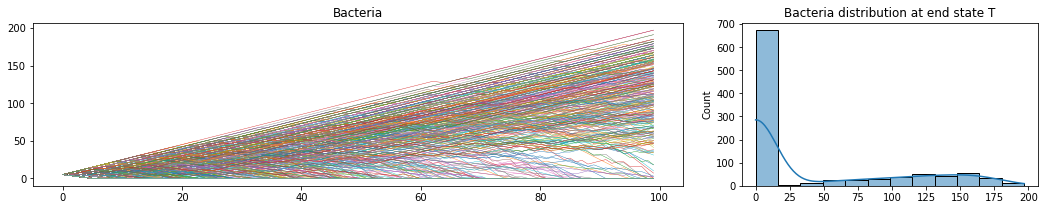

In [33]:
# number of simulations
n=1000
T=100
paths = run_simulations(n, init_state_bacteria, BacteriaInfection, m, n_, bf, delay_ads, T, name, fig_dir)
(len(paths) - np.count_nonzero(paths))/n

# Run models

Here, we can explore several properties

## Checking the relevance of the time to activate the adaptive immune system

0.775
0.739
0.712
0.663
0.657
0.645


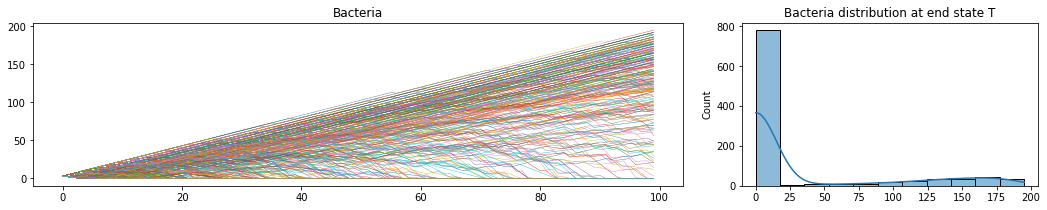

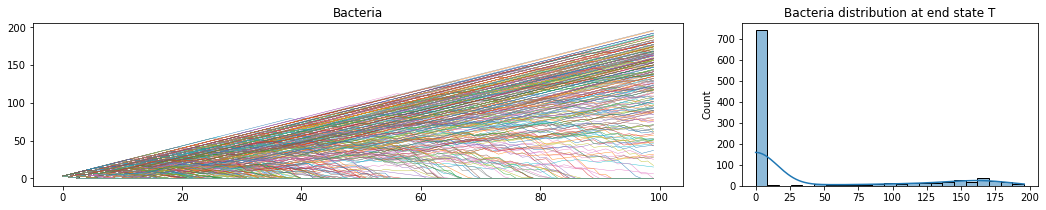

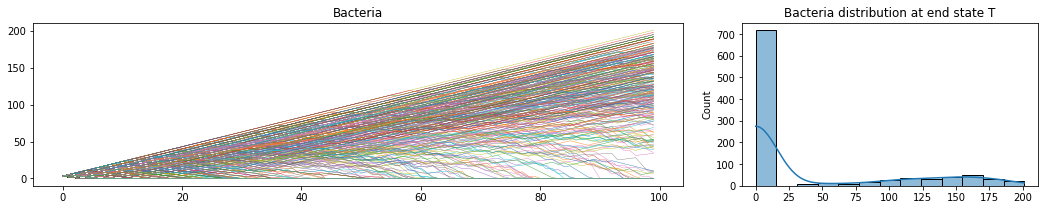

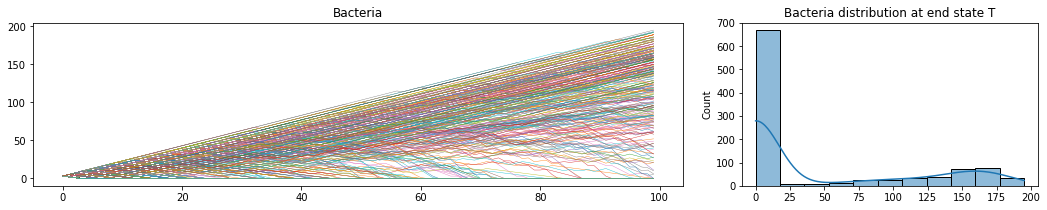

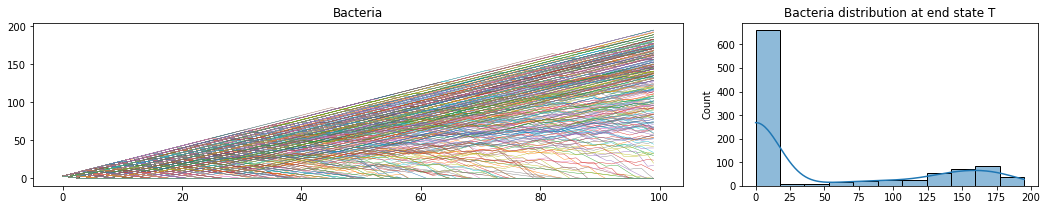

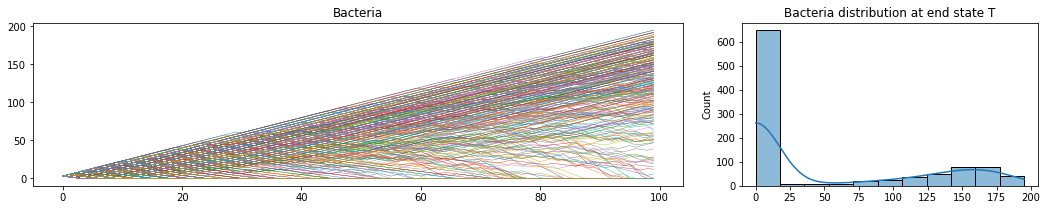

In [39]:
# fix parameters 
n=1000
T=100

# create an instance of the initial state of the system
init_state_bacteria = init_state(lambda_ = 3)

# number of simulations
ts_ads = [1, 5, 10, 15, 20, 25]

for ts in ts_ads: 
    paths = run_simulations(n, init_state_bacteria, BacteriaInfection, m=1, n_=1, bf=2, delay_ads=ts, T=100, exp_name="exp3", fig_dir=fig_dir)
    print((len(paths) - np.count_nonzero(paths))/n)

# Extra: Images for report

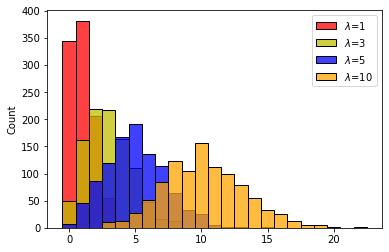

In [112]:
get_ipython().magic('matplotlib inline')

lambdas = [1,3,5,10]
colors = ['r', 'y', 'b', 'orange']

for i, lamba_ in enumerate(lambdas):
    samples = np.random.poisson(lamba_, 1000)
    sns.histplot(samples, discrete=True, color=colors[i], label="$\lambda$={}".format(lamba_))

plt.legend()
plt.savefig(fig_dir + '/poisson.jpg', bbox_inches='tight')

<AxesSubplot:ylabel='Count'>

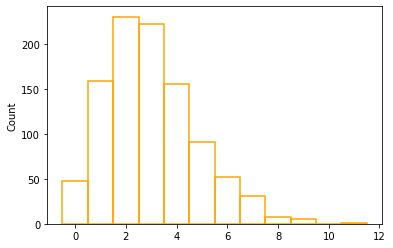

In [109]:
samples = np.random.poisson(3, 1000)
sns.histplot(samples, discrete=True, color=colors[i], label="$\lambda$={}".format(lamba_), fill=False)